In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action="ignore")

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
weather_data = pd.read_csv("weather.csv")
holidays_data = pd.read_csv("holidays.csv")

train_dataset = train_data.copy()
test = test_data.copy()
weather_dataset = weather_data.copy()
holidays_dataset = holidays_data.copy()

In [2]:
holidays_dataset['Ay'] = holidays_dataset['Ay'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
holidays_dataset['Gün'] = holidays_dataset['Gün'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
holidays_dataset["Yıl"] =  holidays_dataset["Yıl"].astype(str) + "-"  +  holidays_dataset["Ay"].astype(str) + "-" +  holidays_dataset["Gün"].astype(str)
holidays_dataset.drop(["Gün","Ay"],axis=1,inplace=True)
holidays_dataset.rename(columns={"Yıl":"Tarih"},inplace=True )
train_dataset["Tatil"] = 0
train_dataset["tarih"] = train_dataset["tarih"].astype(str)
for i, row in train_dataset.iterrows():
    for x in holidays_dataset["Tarih"]:
        if row["tarih"] == x:
            train_dataset.loc[i, "Tatil"] += 1
weather_dataset['date'] = pd.to_datetime(weather_dataset['date'])
weather_dataset['Saat'] = pd.to_datetime(weather_dataset['date']).dt.time
weather_dataset['Yıl'] = pd.to_datetime(weather_dataset['date']).dt.year
weather_dataset['Ay'] = pd.to_datetime(weather_dataset['date']).dt.month
weather_dataset['Gün'] = pd.to_datetime(weather_dataset['date']).dt.day
train_dataset['tarih'] = pd.to_datetime(train_dataset['tarih'])
train_dataset['Yıl'] = pd.to_datetime(train_dataset['tarih']).dt.year
train_dataset['Ay'] = pd.to_datetime(train_dataset['tarih']).dt.month
train_dataset['Gün'] = pd.to_datetime(train_dataset['tarih']).dt.day
train_dataset.drop('tarih',axis=1,inplace=True)
weather_dataset.drop({'date',"lat","lon"},axis=1,inplace=True)
train_dataset["Yıl"]=pd.to_numeric(train_dataset["Yıl"])
train_dataset["Ay"] = pd.to_numeric(train_dataset["Ay"])
train_dataset["Gün"] = pd.to_numeric(train_dataset["Gün"])
weather_dataset["Yıl"]=pd.to_numeric(weather_dataset["Yıl"])
weather_dataset["Ay"] = pd.to_numeric(weather_dataset["Ay"])
weather_dataset["Gün"] = pd.to_numeric(weather_dataset["Gün"])
weather_dataset["Saat"] = pd.to_datetime(weather_dataset['Saat'], format='%H:%M:%S').dt.hour
weather_dataset["Saat"] = pd.to_numeric(weather_dataset["Saat"])
merged_df = pd.merge(train_dataset, weather_dataset, on=("ilce","Yıl","Gün","Ay"))
merged_df = pd.get_dummies(merged_df, columns=['ilce'])

In [3]:
merged_df.columns

Index(['bildirimsiz_sum', 'bildirimli_sum', 'Tatil', 'Yıl', 'Ay', 'Gün',
       't_2m:C', 'effective_cloud_cover:p', 'global_rad:W',
       'relative_humidity_2m:p', 'wind_dir_10m:d', 'wind_speed_10m:ms',
       'prob_precip_1h:p', 't_apparent:C', 'Saat', 'ilce_izmir-aliaga',
       'ilce_izmir-balcova', 'ilce_izmir-bayindir', 'ilce_izmir-bayrakli',
       'ilce_izmir-bergama', 'ilce_izmir-beydag', 'ilce_izmir-bornova',
       'ilce_izmir-buca', 'ilce_izmir-cesme', 'ilce_izmir-cigli',
       'ilce_izmir-dikili', 'ilce_izmir-foca', 'ilce_izmir-gaziemir',
       'ilce_izmir-guzelbahce', 'ilce_izmir-karabaglar',
       'ilce_izmir-karaburun', 'ilce_izmir-karsiyaka', 'ilce_izmir-kemalpasa',
       'ilce_izmir-kinik', 'ilce_izmir-kiraz', 'ilce_izmir-konak',
       'ilce_izmir-menderes', 'ilce_izmir-menemen', 'ilce_izmir-narlidere',
       'ilce_izmir-odemis', 'ilce_izmir-seferihisar', 'ilce_izmir-selcuk',
       'ilce_izmir-tire', 'ilce_izmir-torbali', 'ilce_izmir-urla',
       'ilce_manisa

In [4]:
merged_df.head()

,bildirimsiz_sum,bildirimli_sum,Tatil,Yıl,Ay,Gün,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,...,ilce_manisa-koprubasi,ilce_manisa-kula,ilce_manisa-salihli,ilce_manisa-sarigol,ilce_manisa-saruhanli,ilce_manisa-sehzadeler,ilce_manisa-selendi,ilce_manisa-soma,ilce_manisa-turgutlu,ilce_manisa-yunusemre
0,5,0,1,2021,1,1,10.4,31.5,0.0,92.3,...,0,0,0,0,0,0,0,0,0,0
1,5,0,1,2021,1,1,10.2,56.9,0.0,93.0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,1,2021,1,1,10.2,51.6,0.0,93.9,...,0,0,0,0,0,0,0,0,0,0
3,5,0,1,2021,1,1,10.0,63.7,0.0,95.0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,2021,1,1,10.6,73.2,0.0,97.0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
merged_df.shape

(1155552, 62)

In [6]:
merged_df.columns

Index(['bildirimsiz_sum', 'bildirimli_sum', 'Tatil', 'Yıl', 'Ay', 'Gün',
       't_2m:C', 'effective_cloud_cover:p', 'global_rad:W',
       'relative_humidity_2m:p', 'wind_dir_10m:d', 'wind_speed_10m:ms',
       'prob_precip_1h:p', 't_apparent:C', 'Saat', 'ilce_izmir-aliaga',
       'ilce_izmir-balcova', 'ilce_izmir-bayindir', 'ilce_izmir-bayrakli',
       'ilce_izmir-bergama', 'ilce_izmir-beydag', 'ilce_izmir-bornova',
       'ilce_izmir-buca', 'ilce_izmir-cesme', 'ilce_izmir-cigli',
       'ilce_izmir-dikili', 'ilce_izmir-foca', 'ilce_izmir-gaziemir',
       'ilce_izmir-guzelbahce', 'ilce_izmir-karabaglar',
       'ilce_izmir-karaburun', 'ilce_izmir-karsiyaka', 'ilce_izmir-kemalpasa',
       'ilce_izmir-kinik', 'ilce_izmir-kiraz', 'ilce_izmir-konak',
       'ilce_izmir-menderes', 'ilce_izmir-menemen', 'ilce_izmir-narlidere',
       'ilce_izmir-odemis', 'ilce_izmir-seferihisar', 'ilce_izmir-selcuk',
       'ilce_izmir-tire', 'ilce_izmir-torbali', 'ilce_izmir-urla',
       'ilce_manisa

In [7]:
merged_df.isnull().sum().any()

False

In [8]:
merged_df.duplicated().any()

False

In [9]:
def categorize_weather(temp):
    if temp < 10:
        return 'Soğuk'
    elif temp >= 10 and temp < 20:
        return 'Ilıman'
    else:
        return 'Sıcak'

merged_df['temp_cat'] = merged_df['t_2m:C'].apply(categorize_weather)

In [10]:
merged_df = pd.get_dummies(merged_df, columns=['temp_cat'])

In [11]:
merged_df['cloud_cover_precipitation_interaction'] = merged_df['effective_cloud_cover:p'] * merged_df['prob_precip_1h:p']

In [12]:
merged_df['wind_speed_direction_interaction'] = merged_df['wind_speed_10m:ms'] * merged_df['wind_dir_10m:d']

In [13]:
merged_df.shape

(1155552, 67)

In [14]:
test['Tatil'] = 0

In [15]:
test['tarih'] = pd.to_datetime(test['tarih'])
test['Yıl'] = pd.to_datetime(test['tarih']).dt.year
test['Ay'] = pd.to_datetime(test['tarih']).dt.month
test['Gün'] = pd.to_datetime(test['tarih']).dt.day
test.drop('tarih',axis=1,inplace=True)

In [16]:
test_df = pd.merge(test, weather_dataset, on=("ilce","Yıl","Gün","Ay"))

In [17]:
test_df.shape

(32712, 15)

In [18]:
test_df.isnull().sum()

ilce                       0
bildirimli_sum             0
Tatil                      0
Yıl                        0
Ay                         0
Gün                        0
t_2m:C                     0
effective_cloud_cover:p    0
global_rad:W               0
relative_humidity_2m:p     0
wind_dir_10m:d             0
wind_speed_10m:ms          0
prob_precip_1h:p           0
t_apparent:C               0
Saat                       0
dtype: int64

In [19]:
test_df = pd.get_dummies(test_df, columns=['ilce'])

In [20]:
def categorize_weather(temp):
    if temp < 10:
        return 'Soğuk'
    elif temp >= 10 and temp < 20:
        return 'Ilıman'
    else:
        return 'Sıcak'

test_df['temp_cat'] = test_df['t_2m:C'].apply(categorize_weather)

In [21]:
test_df = pd.get_dummies(test_df, columns=['temp_cat'])

In [22]:
test_df['cloud_cover_precipitation_interaction'] = test_df['effective_cloud_cover:p'] * test_df['prob_precip_1h:p']

In [23]:
test_df['wind_speed_direction_interaction'] = test_df['wind_speed_10m:ms'] * test_df['wind_dir_10m:d']

In [24]:
test_df.tail()

,bildirimli_sum,Tatil,Yıl,Ay,Gün,t_2m:C,effective_cloud_cover:p,global_rad:W,relative_humidity_2m:p,wind_dir_10m:d,...,ilce_manisa-sehzadeler,ilce_manisa-selendi,ilce_manisa-soma,ilce_manisa-turgutlu,ilce_manisa-yunusemre,temp_cat_Ilıman,temp_cat_Soğuk,temp_cat_Sıcak,cloud_cover_precipitation_interaction,wind_speed_direction_interaction
32707,0,0,2024,2,29,17.7,50.1,0.0,60.8,214.2,...,0,0,0,0,0,1,0,0,1097.19,578.34
32708,0,0,2024,2,29,16.5,60.8,0.0,63.9,200.7,...,0,0,0,0,0,1,0,0,547.20,501.75
32709,0,0,2024,2,29,15.8,82.7,0.0,67.5,181.3,...,0,0,0,0,0,1,0,0,6508.49,326.34
32710,0,0,2024,2,29,15.5,87.9,0.0,67.7,151.9,...,0,0,0,0,0,1,0,0,7348.44,212.66
32711,0,0,2024,2,29,14.9,56.7,0.0,69.5,139.8,...,0,0,0,0,0,1,0,0,2375.73,223.68


In [25]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(merged_df, car_th=10)

Observations: 1155552
Variables: 67
cat_cols: 52
num_cols: 15
cat_but_car: 0
num_but_cat: 52


In [26]:
num_cols

['bildirimsiz_sum',
 'bildirimli_sum',
 'Ay',
 'Gün',
 't_2m:C',
 'effective_cloud_cover:p',
 'global_rad:W',
 'relative_humidity_2m:p',
 'wind_dir_10m:d',
 'wind_speed_10m:ms',
 'prob_precip_1h:p',
 't_apparent:C',
 'Saat',
 'cloud_cover_precipitation_interaction',
 'wind_speed_direction_interaction']

In [27]:
cat_cols, num_cols, cat_but_car = grab_col_names(test_df, car_th=10)

Observations: 32712
Variables: 66
cat_cols: 54
num_cols: 12
cat_but_car: 0
num_but_cat: 54


In [28]:
def outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    quantile1 = dataframe[variable].quantile(q1)
    quantile3 = dataframe[variable].quantile(q3)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return low_limit, up_limit


for col in num_cols:
    if col not in ["bildirimsiz_sum", "bildirimli_sum"]:
        print(col, outlier_thresholds(merged_df, col))

Gün (-38.5, 69.5)
t_2m:C (-40.0, 76.0)
effective_cloud_cover:p (-148.64999999999998, 247.74999999999997)
global_rad:W (-1218.4499999999998, 2030.7499999999998)
relative_humidity_2m:p (-73.30000000000001, 193.90000000000003)
wind_dir_10m:d (-507.4000000000001, 865.4000000000001)
wind_speed_10m:ms (-8.350000000000001, 15.250000000000002)
prob_precip_1h:p (-8.149999999999999, 16.25)
t_apparent:C (-51.199999999999996, 90.39999999999999)
Saat (-30.5, 53.5)
cloud_cover_precipitation_interaction (-769.5, 1282.5)
wind_speed_direction_interaction (-2098.425, 3542.175)


In [29]:
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    
    if dataframe[(dataframe[column] > up_limit) | (dataframe[column] < low_limit)].any(axis=None):
        return True
    
    else:
        return False
    
    
for col in num_cols:
    print(col, check_outlier(merged_df, col))

Gün False
t_2m:C False
effective_cloud_cover:p False
global_rad:W False
relative_humidity_2m:p False
wind_dir_10m:d False
wind_speed_10m:ms True
prob_precip_1h:p True
t_apparent:C False
Saat False
cloud_cover_precipitation_interaction True
wind_speed_direction_interaction True


In [30]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col not in ["bildirimsiz_sum", "bildirimli_sum"]:
        replace_with_thresholds(merged_df, col)

In [31]:
y_train = merged_df["bildirimsiz_sum"]
y_train_log = np.log1p(y_train)
X_train = merged_df.drop(["bildirimsiz_sum", "t_2m:C", "global_rad:W", "wind_speed_10m:ms", "wind_dir_10m:d"], axis=1)
X_test = test_df.copy()
X_test.drop(["t_2m:C", "global_rad:W", "wind_speed_10m:ms", "wind_dir_10m:d"], axis=1, inplace=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
cat_model = CatBoostRegressor(random_state=42)

cat_params = {
    "iterations": [500, 600, 700],
    "learning_rate": [0.05, 0.1, 0.3],
    "depth": [5, 7, 9]
}

randomized_search = RandomizedSearchCV(cat_model, cat_params, cv=3, n_iter=10, n_jobs=-1, verbose=True)
randomized_search.fit(X_train_scaled, y_train_log)
best_params = randomized_search.best_params_

cat_final = CatBoostRegressor(**best_params, random_state=42)
cat_final.fit(X_train_scaled, y_train_log)

cv_results = cross_validate(cat_final, X_train_scaled, y_train_log, cv=3, scoring=["neg_mean_squared_error"])
avg_mse = -cv_results["test_neg_mean_squared_error"].mean()

print("Average MSE:", avg_mse)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 0.6980953	total: 333ms	remaining: 3m 19s
1:	learn: 0.6877677	total: 623ms	remaining: 3m 6s
2:	learn: 0.6784094	total: 846ms	remaining: 2m 48s
3:	learn: 0.6698468	total: 1.25s	remaining: 3m 6s
4:	learn: 0.6623140	total: 1.45s	remaining: 2m 52s
5:	learn: 0.6551611	total: 1.66s	remaining: 2m 43s
6:	learn: 0.6484950	total: 1.95s	remaining: 2m 45s
7:	learn: 0.6428051	total: 2.3s	remaining: 2m 50s
8:	learn: 0.6371099	total: 2.49s	remaining: 2m 43s
9:	learn: 0.6321752	total: 2.69s	remaining: 2m 38s
10:	learn: 0.6274716	total: 2.97s	remaining: 2m 38s
11:	learn: 0.6230537	total: 3.26s	remaining: 2m 39s
12:	learn: 0.6190748	total: 3.58s	remaining: 2m 41s
13:	learn: 0.6155028	total: 3.81s	remaining: 2m 39s
14:	learn: 0.6118151	total: 4.03s	remaining: 2m 37s
15:	learn: 0.6086017	total: 4.35s	remaining: 2m 38s
16:	learn: 0.6056435	total: 4.56s	remaining: 2m 36s
17:	learn: 0.6028204	total: 4.8s	remaining: 2m 35s
18:	learn: 0.6000

157:	learn: 0.5000656	total: 45.4s	remaining: 2m 7s
158:	learn: 0.4996992	total: 45.7s	remaining: 2m 6s
159:	learn: 0.4994685	total: 46s	remaining: 2m 6s
160:	learn: 0.4991171	total: 46.3s	remaining: 2m 6s
161:	learn: 0.4988028	total: 46.6s	remaining: 2m 6s
162:	learn: 0.4985882	total: 46.9s	remaining: 2m 5s
163:	learn: 0.4983677	total: 47.2s	remaining: 2m 5s
164:	learn: 0.4980507	total: 47.5s	remaining: 2m 5s
165:	learn: 0.4978251	total: 47.8s	remaining: 2m 4s
166:	learn: 0.4976525	total: 48.1s	remaining: 2m 4s
167:	learn: 0.4973361	total: 48.3s	remaining: 2m 4s
168:	learn: 0.4971454	total: 48.6s	remaining: 2m 4s
169:	learn: 0.4969317	total: 48.9s	remaining: 2m 3s
170:	learn: 0.4966810	total: 49.2s	remaining: 2m 3s
171:	learn: 0.4965098	total: 49.5s	remaining: 2m 3s
172:	learn: 0.4962716	total: 49.9s	remaining: 2m 3s
173:	learn: 0.4960723	total: 50.2s	remaining: 2m 2s
174:	learn: 0.4957442	total: 50.5s	remaining: 2m 2s
175:	learn: 0.4952978	total: 50.8s	remaining: 2m 2s
176:	learn: 0.

311:	learn: 0.4672332	total: 1m 32s	remaining: 1m 25s
312:	learn: 0.4671024	total: 1m 33s	remaining: 1m 25s
313:	learn: 0.4669437	total: 1m 33s	remaining: 1m 25s
314:	learn: 0.4668136	total: 1m 33s	remaining: 1m 25s
315:	learn: 0.4666139	total: 1m 34s	remaining: 1m 25s
316:	learn: 0.4664962	total: 1m 34s	remaining: 1m 24s
317:	learn: 0.4663697	total: 1m 34s	remaining: 1m 24s
318:	learn: 0.4661599	total: 1m 35s	remaining: 1m 24s
319:	learn: 0.4660042	total: 1m 35s	remaining: 1m 23s
320:	learn: 0.4657987	total: 1m 35s	remaining: 1m 23s
321:	learn: 0.4656474	total: 1m 36s	remaining: 1m 23s
322:	learn: 0.4654711	total: 1m 36s	remaining: 1m 22s
323:	learn: 0.4652921	total: 1m 36s	remaining: 1m 22s
324:	learn: 0.4651235	total: 1m 37s	remaining: 1m 22s
325:	learn: 0.4649911	total: 1m 37s	remaining: 1m 22s
326:	learn: 0.4648073	total: 1m 37s	remaining: 1m 21s
327:	learn: 0.4647146	total: 1m 38s	remaining: 1m 21s
328:	learn: 0.4645403	total: 1m 38s	remaining: 1m 21s
329:	learn: 0.4644363	total:

466:	learn: 0.4472568	total: 2m 31s	remaining: 43.3s
467:	learn: 0.4471883	total: 2m 32s	remaining: 43.1s
468:	learn: 0.4470870	total: 2m 32s	remaining: 42.8s
469:	learn: 0.4469607	total: 2m 33s	remaining: 42.6s
470:	learn: 0.4469017	total: 2m 34s	remaining: 42.3s
471:	learn: 0.4468111	total: 2m 34s	remaining: 42s
472:	learn: 0.4466379	total: 2m 34s	remaining: 41.7s
473:	learn: 0.4464442	total: 2m 35s	remaining: 41.4s
474:	learn: 0.4463106	total: 2m 35s	remaining: 41s
475:	learn: 0.4462273	total: 2m 35s	remaining: 40.7s
476:	learn: 0.4461253	total: 2m 36s	remaining: 40.4s
477:	learn: 0.4460344	total: 2m 36s	remaining: 40.1s
478:	learn: 0.4459490	total: 2m 37s	remaining: 39.8s
479:	learn: 0.4458144	total: 2m 37s	remaining: 39.5s
480:	learn: 0.4457106	total: 2m 37s	remaining: 39.1s
481:	learn: 0.4455690	total: 2m 37s	remaining: 38.7s
482:	learn: 0.4454943	total: 2m 37s	remaining: 38.4s
483:	learn: 0.4454274	total: 2m 38s	remaining: 38s
484:	learn: 0.4453341	total: 2m 38s	remaining: 37.6s

24:	learn: 0.5865501	total: 7.07s	remaining: 2m 42s
25:	learn: 0.5847116	total: 7.38s	remaining: 2m 42s
26:	learn: 0.5829464	total: 7.68s	remaining: 2m 43s
27:	learn: 0.5812480	total: 7.92s	remaining: 2m 41s
28:	learn: 0.5796660	total: 8.2s	remaining: 2m 41s
29:	learn: 0.5781637	total: 8.42s	remaining: 2m 39s
30:	learn: 0.5766544	total: 8.92s	remaining: 2m 43s
31:	learn: 0.5748822	total: 9.16s	remaining: 2m 42s
32:	learn: 0.5730756	total: 9.45s	remaining: 2m 42s
33:	learn: 0.5718297	total: 9.71s	remaining: 2m 41s
34:	learn: 0.5701980	total: 10.2s	remaining: 2m 44s
35:	learn: 0.5688882	total: 10.4s	remaining: 2m 43s
36:	learn: 0.5677632	total: 10.7s	remaining: 2m 42s
37:	learn: 0.5666609	total: 10.9s	remaining: 2m 40s
38:	learn: 0.5656356	total: 11.1s	remaining: 2m 39s
39:	learn: 0.5641364	total: 11.4s	remaining: 2m 39s
40:	learn: 0.5631097	total: 11.7s	remaining: 2m 39s
41:	learn: 0.5617847	total: 12.4s	remaining: 2m 44s
42:	learn: 0.5607488	total: 12.8s	remaining: 2m 45s
43:	learn: 0.

182:	learn: 0.4933315	total: 55s	remaining: 2m 5s
183:	learn: 0.4931272	total: 55.3s	remaining: 2m 4s
184:	learn: 0.4928515	total: 55.8s	remaining: 2m 5s
185:	learn: 0.4926697	total: 56.1s	remaining: 2m 4s
186:	learn: 0.4925193	total: 56.5s	remaining: 2m 4s
187:	learn: 0.4923425	total: 56.9s	remaining: 2m 4s
188:	learn: 0.4920532	total: 57.2s	remaining: 2m 4s
189:	learn: 0.4918618	total: 57.6s	remaining: 2m 4s
190:	learn: 0.4916681	total: 57.9s	remaining: 2m 4s
191:	learn: 0.4914586	total: 58.3s	remaining: 2m 3s
192:	learn: 0.4913089	total: 58.5s	remaining: 2m 3s
193:	learn: 0.4910501	total: 58.8s	remaining: 2m 3s
194:	learn: 0.4908443	total: 59.1s	remaining: 2m 2s
195:	learn: 0.4906589	total: 59.5s	remaining: 2m 2s
196:	learn: 0.4904359	total: 59.8s	remaining: 2m 2s
197:	learn: 0.4901369	total: 1m	remaining: 2m 2s
198:	learn: 0.4898384	total: 1m	remaining: 2m 1s
199:	learn: 0.4895099	total: 1m	remaining: 2m 1s
200:	learn: 0.4892852	total: 1m	remaining: 2m 1s
201:	learn: 0.4889969	tota

336:	learn: 0.4633582	total: 1m 53s	remaining: 1m 28s
337:	learn: 0.4632359	total: 1m 54s	remaining: 1m 28s
338:	learn: 0.4630999	total: 1m 54s	remaining: 1m 28s
339:	learn: 0.4629728	total: 1m 54s	remaining: 1m 27s
340:	learn: 0.4627461	total: 1m 55s	remaining: 1m 27s
341:	learn: 0.4625715	total: 1m 55s	remaining: 1m 27s
342:	learn: 0.4624037	total: 1m 56s	remaining: 1m 26s
343:	learn: 0.4622669	total: 1m 56s	remaining: 1m 26s
344:	learn: 0.4621296	total: 1m 56s	remaining: 1m 26s
345:	learn: 0.4620179	total: 1m 57s	remaining: 1m 26s
346:	learn: 0.4618826	total: 1m 57s	remaining: 1m 25s
347:	learn: 0.4617548	total: 1m 58s	remaining: 1m 25s
348:	learn: 0.4616312	total: 1m 58s	remaining: 1m 25s
349:	learn: 0.4614612	total: 1m 58s	remaining: 1m 24s
350:	learn: 0.4613501	total: 1m 59s	remaining: 1m 24s
351:	learn: 0.4611582	total: 2m	remaining: 1m 24s
352:	learn: 0.4610398	total: 2m	remaining: 1m 24s
353:	learn: 0.4608903	total: 2m	remaining: 1m 24s
354:	learn: 0.4607284	total: 2m 1s	remai

491:	learn: 0.4446181	total: 2m 56s	remaining: 38.6s
492:	learn: 0.4445645	total: 2m 56s	remaining: 38.3s
493:	learn: 0.4444581	total: 2m 56s	remaining: 37.9s
494:	learn: 0.4443671	total: 2m 57s	remaining: 37.6s
495:	learn: 0.4442833	total: 2m 57s	remaining: 37.2s
496:	learn: 0.4441769	total: 2m 57s	remaining: 36.9s
497:	learn: 0.4440957	total: 2m 58s	remaining: 36.5s
498:	learn: 0.4439867	total: 2m 58s	remaining: 36.1s
499:	learn: 0.4438336	total: 2m 58s	remaining: 35.8s
500:	learn: 0.4437047	total: 2m 59s	remaining: 35.4s
501:	learn: 0.4435910	total: 2m 59s	remaining: 35s
502:	learn: 0.4435232	total: 2m 59s	remaining: 34.7s
503:	learn: 0.4434208	total: 3m	remaining: 34.3s
504:	learn: 0.4432920	total: 3m	remaining: 34s
505:	learn: 0.4432341	total: 3m	remaining: 33.6s
506:	learn: 0.4431282	total: 3m 1s	remaining: 33.3s
507:	learn: 0.4430458	total: 3m 1s	remaining: 32.9s
508:	learn: 0.4429749	total: 3m 2s	remaining: 32.5s
509:	learn: 0.4428769	total: 3m 2s	remaining: 32.2s
510:	learn: 0

49:	learn: 0.5350340	total: 10.1s	remaining: 1m 50s
50:	learn: 0.5341863	total: 10.3s	remaining: 1m 51s
51:	learn: 0.5331199	total: 10.6s	remaining: 1m 51s
52:	learn: 0.5320166	total: 10.8s	remaining: 1m 51s
53:	learn: 0.5305371	total: 11s	remaining: 1m 51s
54:	learn: 0.5295491	total: 11.2s	remaining: 1m 50s
55:	learn: 0.5282302	total: 11.4s	remaining: 1m 51s
56:	learn: 0.5275871	total: 11.6s	remaining: 1m 50s
57:	learn: 0.5265957	total: 11.8s	remaining: 1m 50s
58:	learn: 0.5259641	total: 12s	remaining: 1m 49s
59:	learn: 0.5250450	total: 12.2s	remaining: 1m 49s
60:	learn: 0.5243782	total: 12.4s	remaining: 1m 49s
61:	learn: 0.5232132	total: 12.6s	remaining: 1m 49s
62:	learn: 0.5224774	total: 12.8s	remaining: 1m 49s
63:	learn: 0.5218322	total: 13s	remaining: 1m 48s
64:	learn: 0.5210567	total: 13.2s	remaining: 1m 48s
65:	learn: 0.5204361	total: 13.4s	remaining: 1m 48s
66:	learn: 0.5196905	total: 13.6s	remaining: 1m 48s
67:	learn: 0.5189277	total: 13.8s	remaining: 1m 48s
68:	learn: 0.51812

206:	learn: 0.4663967	total: 48.5s	remaining: 1m 32s
207:	learn: 0.4661560	total: 48.8s	remaining: 1m 31s
208:	learn: 0.4659589	total: 49s	remaining: 1m 31s
209:	learn: 0.4656091	total: 49.2s	remaining: 1m 31s
210:	learn: 0.4653672	total: 49.4s	remaining: 1m 31s
211:	learn: 0.4651310	total: 49.6s	remaining: 1m 30s
212:	learn: 0.4648291	total: 49.9s	remaining: 1m 30s
213:	learn: 0.4646230	total: 50.2s	remaining: 1m 30s
214:	learn: 0.4644503	total: 50.3s	remaining: 1m 30s
215:	learn: 0.4641631	total: 50.6s	remaining: 1m 29s
216:	learn: 0.4639809	total: 50.9s	remaining: 1m 29s
217:	learn: 0.4637463	total: 51.1s	remaining: 1m 29s
218:	learn: 0.4634950	total: 51.3s	remaining: 1m 29s
219:	learn: 0.4633093	total: 51.6s	remaining: 1m 29s
220:	learn: 0.4631602	total: 51.8s	remaining: 1m 28s
221:	learn: 0.4628896	total: 52.1s	remaining: 1m 28s
222:	learn: 0.4626872	total: 52.4s	remaining: 1m 28s
223:	learn: 0.4624796	total: 52.7s	remaining: 1m 28s
224:	learn: 0.4622610	total: 52.9s	remaining: 1m

361:	learn: 0.4374016	total: 1m 26s	remaining: 57s
362:	learn: 0.4372713	total: 1m 26s	remaining: 56.7s
363:	learn: 0.4371951	total: 1m 27s	remaining: 56.5s
364:	learn: 0.4370692	total: 1m 27s	remaining: 56.3s
365:	learn: 0.4369046	total: 1m 27s	remaining: 56.1s
366:	learn: 0.4368033	total: 1m 27s	remaining: 55.8s
367:	learn: 0.4366702	total: 1m 28s	remaining: 55.6s
368:	learn: 0.4365031	total: 1m 28s	remaining: 55.3s
369:	learn: 0.4363662	total: 1m 28s	remaining: 55.1s
370:	learn: 0.4361585	total: 1m 28s	remaining: 54.8s
371:	learn: 0.4359713	total: 1m 29s	remaining: 54.6s
372:	learn: 0.4358329	total: 1m 29s	remaining: 54.4s
373:	learn: 0.4356942	total: 1m 29s	remaining: 54.1s
374:	learn: 0.4355410	total: 1m 29s	remaining: 53.9s
375:	learn: 0.4353977	total: 1m 30s	remaining: 53.9s
376:	learn: 0.4352622	total: 1m 30s	remaining: 53.8s
377:	learn: 0.4350563	total: 1m 31s	remaining: 53.6s
378:	learn: 0.4349311	total: 1m 31s	remaining: 53.3s
379:	learn: 0.4348235	total: 1m 31s	remaining: 5

518:	learn: 0.4181207	total: 2m 6s	remaining: 19.8s
519:	learn: 0.4180410	total: 2m 7s	remaining: 19.6s
520:	learn: 0.4179443	total: 2m 7s	remaining: 19.3s
521:	learn: 0.4178314	total: 2m 7s	remaining: 19.1s
522:	learn: 0.4177309	total: 2m 7s	remaining: 18.8s
523:	learn: 0.4176553	total: 2m 8s	remaining: 18.6s
524:	learn: 0.4175766	total: 2m 8s	remaining: 18.3s
525:	learn: 0.4174385	total: 2m 8s	remaining: 18.1s
526:	learn: 0.4173395	total: 2m 8s	remaining: 17.9s
527:	learn: 0.4172408	total: 2m 9s	remaining: 17.6s
528:	learn: 0.4171401	total: 2m 10s	remaining: 17.5s
529:	learn: 0.4170572	total: 2m 10s	remaining: 17.3s
530:	learn: 0.4169629	total: 2m 11s	remaining: 17.1s
531:	learn: 0.4168962	total: 2m 11s	remaining: 16.8s
532:	learn: 0.4168086	total: 2m 11s	remaining: 16.6s
533:	learn: 0.4166980	total: 2m 11s	remaining: 16.3s
534:	learn: 0.4165971	total: 2m 12s	remaining: 16.1s
535:	learn: 0.4165586	total: 2m 12s	remaining: 15.8s
536:	learn: 0.4164197	total: 2m 12s	remaining: 15.6s
537

76:	learn: 0.5129962	total: 16.6s	remaining: 1m 53s
77:	learn: 0.5125310	total: 16.8s	remaining: 1m 52s
78:	learn: 0.5121136	total: 17.1s	remaining: 1m 52s
79:	learn: 0.5116190	total: 17.7s	remaining: 1m 55s
80:	learn: 0.5111955	total: 18.1s	remaining: 1m 55s
81:	learn: 0.5108421	total: 18.5s	remaining: 1m 56s
82:	learn: 0.5104481	total: 18.7s	remaining: 1m 56s
83:	learn: 0.5099158	total: 18.9s	remaining: 1m 56s
84:	learn: 0.5093624	total: 19s	remaining: 1m 55s
85:	learn: 0.5088333	total: 19.3s	remaining: 1m 55s
86:	learn: 0.5082843	total: 19.7s	remaining: 1m 55s
87:	learn: 0.5077747	total: 19.9s	remaining: 1m 56s
88:	learn: 0.5072101	total: 20.2s	remaining: 1m 55s
89:	learn: 0.5068389	total: 20.5s	remaining: 1m 56s
90:	learn: 0.5063725	total: 20.8s	remaining: 1m 56s
91:	learn: 0.5057844	total: 21.1s	remaining: 1m 56s
92:	learn: 0.5053940	total: 21.3s	remaining: 1m 56s
93:	learn: 0.5051411	total: 21.5s	remaining: 1m 55s
94:	learn: 0.5047754	total: 21.7s	remaining: 1m 55s
95:	learn: 0.5

232:	learn: 0.4648932	total: 59.3s	remaining: 1m 33s
233:	learn: 0.4647243	total: 59.5s	remaining: 1m 33s
234:	learn: 0.4645037	total: 59.7s	remaining: 1m 32s
235:	learn: 0.4642180	total: 59.9s	remaining: 1m 32s
236:	learn: 0.4640331	total: 1m	remaining: 1m 31s
237:	learn: 0.4637508	total: 1m	remaining: 1m 31s
238:	learn: 0.4635061	total: 1m	remaining: 1m 31s
239:	learn: 0.4633728	total: 1m	remaining: 1m 30s
240:	learn: 0.4632666	total: 1m	remaining: 1m 30s
241:	learn: 0.4629802	total: 1m 1s	remaining: 1m 30s
242:	learn: 0.4627010	total: 1m 1s	remaining: 1m 30s
243:	learn: 0.4624539	total: 1m 1s	remaining: 1m 29s
244:	learn: 0.4623341	total: 1m 1s	remaining: 1m 29s
245:	learn: 0.4621718	total: 1m 2s	remaining: 1m 29s
246:	learn: 0.4618879	total: 1m 2s	remaining: 1m 28s
247:	learn: 0.4616992	total: 1m 2s	remaining: 1m 28s
248:	learn: 0.4614752	total: 1m 2s	remaining: 1m 28s
249:	learn: 0.4611903	total: 1m 3s	remaining: 1m 28s
250:	learn: 0.4610289	total: 1m 3s	remaining: 1m 27s
251:	lea

387:	learn: 0.4397246	total: 1m 39s	remaining: 54.6s
388:	learn: 0.4395626	total: 1m 40s	remaining: 54.3s
389:	learn: 0.4394383	total: 1m 40s	remaining: 54s
390:	learn: 0.4393339	total: 1m 40s	remaining: 53.7s
391:	learn: 0.4392423	total: 1m 40s	remaining: 53.4s
392:	learn: 0.4390897	total: 1m 40s	remaining: 53.2s
393:	learn: 0.4389909	total: 1m 41s	remaining: 52.9s
394:	learn: 0.4389028	total: 1m 41s	remaining: 52.6s
395:	learn: 0.4387577	total: 1m 41s	remaining: 52.3s
396:	learn: 0.4386478	total: 1m 41s	remaining: 52.1s
397:	learn: 0.4385152	total: 1m 42s	remaining: 51.8s
398:	learn: 0.4384510	total: 1m 42s	remaining: 51.5s
399:	learn: 0.4383372	total: 1m 42s	remaining: 51.3s
400:	learn: 0.4382330	total: 1m 42s	remaining: 51s
401:	learn: 0.4380721	total: 1m 43s	remaining: 50.7s
402:	learn: 0.4379505	total: 1m 43s	remaining: 50.5s
403:	learn: 0.4377943	total: 1m 43s	remaining: 50.2s
404:	learn: 0.4376146	total: 1m 43s	remaining: 49.9s
405:	learn: 0.4374866	total: 1m 43s	remaining: 49.

543:	learn: 0.4226314	total: 2m 27s	remaining: 15.2s
544:	learn: 0.4225232	total: 2m 27s	remaining: 14.9s
545:	learn: 0.4224431	total: 2m 27s	remaining: 14.6s
546:	learn: 0.4223268	total: 2m 28s	remaining: 14.4s
547:	learn: 0.4222206	total: 2m 28s	remaining: 14.1s
548:	learn: 0.4221405	total: 2m 28s	remaining: 13.8s
549:	learn: 0.4220696	total: 2m 29s	remaining: 13.6s
550:	learn: 0.4219636	total: 2m 29s	remaining: 13.3s
551:	learn: 0.4218426	total: 2m 29s	remaining: 13s
552:	learn: 0.4217156	total: 2m 29s	remaining: 12.7s
553:	learn: 0.4216568	total: 2m 30s	remaining: 12.5s
554:	learn: 0.4215693	total: 2m 30s	remaining: 12.2s
555:	learn: 0.4214255	total: 2m 30s	remaining: 11.9s
556:	learn: 0.4213608	total: 2m 31s	remaining: 11.7s
557:	learn: 0.4212495	total: 2m 31s	remaining: 11.4s
558:	learn: 0.4211282	total: 2m 31s	remaining: 11.1s
559:	learn: 0.4210668	total: 2m 31s	remaining: 10.8s
560:	learn: 0.4210023	total: 2m 31s	remaining: 10.6s
561:	learn: 0.4209556	total: 2m 32s	remaining: 1

102:	learn: 0.5065634	total: 26.6s	remaining: 2m 8s
103:	learn: 0.5059666	total: 26.8s	remaining: 2m 7s
104:	learn: 0.5056269	total: 27s	remaining: 2m 7s
105:	learn: 0.5051445	total: 27.2s	remaining: 2m 6s
106:	learn: 0.5046605	total: 27.5s	remaining: 2m 6s
107:	learn: 0.5043025	total: 27.7s	remaining: 2m 6s
108:	learn: 0.5039124	total: 27.9s	remaining: 2m 5s
109:	learn: 0.5034942	total: 28.1s	remaining: 2m 5s
110:	learn: 0.5027577	total: 28.4s	remaining: 2m 4s
111:	learn: 0.5023326	total: 28.7s	remaining: 2m 4s
112:	learn: 0.5020477	total: 28.9s	remaining: 2m 4s
113:	learn: 0.5017799	total: 29.1s	remaining: 2m 3s
114:	learn: 0.5013496	total: 29.3s	remaining: 2m 3s
115:	learn: 0.5011759	total: 29.5s	remaining: 2m 2s
116:	learn: 0.5007854	total: 29.7s	remaining: 2m 2s
117:	learn: 0.5004969	total: 29.8s	remaining: 2m 1s
118:	learn: 0.5001841	total: 30.2s	remaining: 2m 1s
119:	learn: 0.4998448	total: 30.4s	remaining: 2m 1s
120:	learn: 0.4995497	total: 30.6s	remaining: 2m 1s
121:	learn: 0.

258:	learn: 0.4616250	total: 1m 1s	remaining: 1m 21s
259:	learn: 0.4614412	total: 1m 2s	remaining: 1m 21s
260:	learn: 0.4612634	total: 1m 2s	remaining: 1m 20s
261:	learn: 0.4611200	total: 1m 2s	remaining: 1m 20s
262:	learn: 0.4609622	total: 1m 2s	remaining: 1m 20s
263:	learn: 0.4607932	total: 1m 2s	remaining: 1m 20s
264:	learn: 0.4605934	total: 1m 3s	remaining: 1m 19s
265:	learn: 0.4603985	total: 1m 3s	remaining: 1m 19s
266:	learn: 0.4601165	total: 1m 3s	remaining: 1m 19s
267:	learn: 0.4599675	total: 1m 3s	remaining: 1m 19s
268:	learn: 0.4597768	total: 1m 4s	remaining: 1m 19s
269:	learn: 0.4596667	total: 1m 4s	remaining: 1m 18s
270:	learn: 0.4594516	total: 1m 4s	remaining: 1m 18s
271:	learn: 0.4592238	total: 1m 4s	remaining: 1m 18s
272:	learn: 0.4590373	total: 1m 5s	remaining: 1m 18s
273:	learn: 0.4589099	total: 1m 5s	remaining: 1m 17s
274:	learn: 0.4587832	total: 1m 5s	remaining: 1m 17s
275:	learn: 0.4586210	total: 1m 5s	remaining: 1m 17s
276:	learn: 0.4584205	total: 1m 6s	remaining: 

414:	learn: 0.4372825	total: 1m 40s	remaining: 45s
415:	learn: 0.4371029	total: 1m 41s	remaining: 44.8s
416:	learn: 0.4369307	total: 1m 41s	remaining: 44.7s
417:	learn: 0.4367899	total: 1m 42s	remaining: 44.5s
418:	learn: 0.4366313	total: 1m 42s	remaining: 44.3s
419:	learn: 0.4365199	total: 1m 42s	remaining: 44.1s
420:	learn: 0.4364080	total: 1m 43s	remaining: 43.9s
421:	learn: 0.4363124	total: 1m 43s	remaining: 43.7s
422:	learn: 0.4361557	total: 1m 43s	remaining: 43.4s
423:	learn: 0.4360183	total: 1m 44s	remaining: 43.2s
424:	learn: 0.4358817	total: 1m 44s	remaining: 43s
425:	learn: 0.4357479	total: 1m 44s	remaining: 42.7s
426:	learn: 0.4355931	total: 1m 44s	remaining: 42.5s
427:	learn: 0.4354491	total: 1m 45s	remaining: 42.2s
428:	learn: 0.4353616	total: 1m 45s	remaining: 42s
429:	learn: 0.4353035	total: 1m 45s	remaining: 41.7s
430:	learn: 0.4351788	total: 1m 45s	remaining: 41.4s
431:	learn: 0.4350673	total: 1m 45s	remaining: 41.2s
432:	learn: 0.4349056	total: 1m 46s	remaining: 40.9s

571:	learn: 0.4196477	total: 2m 22s	remaining: 6.96s
572:	learn: 0.4195221	total: 2m 22s	remaining: 6.71s
573:	learn: 0.4194244	total: 2m 22s	remaining: 6.46s
574:	learn: 0.4193377	total: 2m 22s	remaining: 6.21s
575:	learn: 0.4192464	total: 2m 23s	remaining: 5.96s
576:	learn: 0.4191252	total: 2m 23s	remaining: 5.71s
577:	learn: 0.4190278	total: 2m 23s	remaining: 5.47s
578:	learn: 0.4189753	total: 2m 23s	remaining: 5.22s
579:	learn: 0.4188752	total: 2m 24s	remaining: 4.97s
580:	learn: 0.4187693	total: 2m 24s	remaining: 4.72s
581:	learn: 0.4186546	total: 2m 24s	remaining: 4.47s
582:	learn: 0.4185844	total: 2m 24s	remaining: 4.22s
583:	learn: 0.4184609	total: 2m 25s	remaining: 3.97s
584:	learn: 0.4183102	total: 2m 25s	remaining: 3.72s
585:	learn: 0.4182123	total: 2m 25s	remaining: 3.48s
586:	learn: 0.4181376	total: 2m 25s	remaining: 3.23s
587:	learn: 0.4180395	total: 2m 25s	remaining: 2.98s
588:	learn: 0.4179174	total: 2m 26s	remaining: 2.73s
589:	learn: 0.4178386	total: 2m 26s	remaining:

In [33]:
best_params

{'learning_rate': 0.1, 'iterations': 600, 'depth': 9}

In [34]:
y_pred_log = cat_final.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

In [35]:
y_pred[y_pred < 0] = 0

predict_submisson = pd.read_csv("sample_submission.csv")

test_df["bildirimsiz_sum"] = y_pred

test_df["Yıl"] =test_df["Yıl"].astype(str) + "-"  +  test_df["Ay"].astype(str) + "-" +  test_df["Gün"].astype(str)

columns_to_drop = [
    "Tatil", "Ay", "Gün", "t_2m:C", "effective_cloud_cover:p",
    "global_rad:W", "relative_humidity_2m:p", "wind_dir_10m:d",
    "wind_speed_10m:ms", "prob_precip_1h:p", "t_apparent:C", "Saat"
]
cleaned_df = test_df.drop(columns=columns_to_drop)

cleaned_df.groupby(["Yıl"])
df=cleaned_df

cleaned_df.drop("bildirimli_sum",axis=1,inplace=True)

predict_submisson["bildirimsiz_sum"] = round(df["bildirimsiz_sum"])

predict_submisson.to_csv('predictions.csv',index=False)

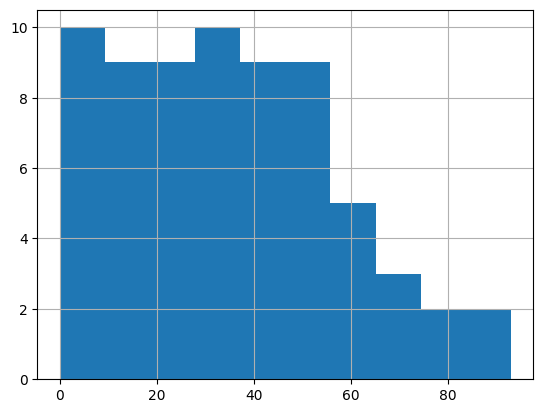

In [36]:
import matplotlib.pyplot as plt
bildirimsiz_sum = [5, 13, 4, 9, 2, 3, 8, 14, 1, 24, 12, 6, 22, 16, 11, 7, 10, 15, 18, 25, 0, 31, 23, 17, 21, 19, 30, 32, 20, 29, 26, 57, 34, 54, 28, 33, 36, 27, 53, 55, 63, 47, 37, 74, 35, 40, 46, 51, 48, 38, 39, 42, 43, 49, 41, 50, 44, 45, 93, 78, 88, 58, 52, 76, 56, 68, 67, 60]
plt.hist(bildirimsiz_sum)
plt.grid(True)
plt.show()

In [37]:
feature_importances = cat_final.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = feature_names[sorted_indices]
for i, feature in enumerate(sorted_features):
    print(f"{i+1}. {feature}: {feature_importances[sorted_indices[i]]}")

1. Gün: 16.631665917222225
2. Ay: 13.9920589225043
3. Yıl: 10.480976365436131
4. bildirimli_sum: 3.7238233863597974
5. ilce_izmir-cesme: 3.2168401526615207
6. ilce_manisa-koprubasi: 2.27542477445203
7. ilce_izmir-selcuk: 2.027579668485656
8. ilce_izmir-balcova: 2.004278945688979
9. ilce_manisa-golmarmara: 1.9180288639881191
10. ilce_manisa-ahmetli: 1.9001608905581364
11. ilce_izmir-narlidere: 1.8862708361723406
12. ilce_manisa-demirci: 1.8680079009340333
13. ilce_izmir-odemis: 1.8668376556644757
14. ilce_manisa-yunusemre: 1.8244670780978196
15. ilce_izmir-konak: 1.7782661677235128
16. ilce_izmir-kinik: 1.7268086944151355
17. ilce_izmir-beydag: 1.7179323272989606
18. ilce_izmir-guzelbahce: 1.5498908328590841
19. ilce_manisa-kirkagac: 1.5449026153197853
20. ilce_izmir-bornova: 1.5228074313494073
21. ilce_izmir-gaziemir: 1.4923290172054713
22. ilce_izmir-urla: 1.4166398353885885
23. ilce_manisa-salihli: 1.4007289520495794
24. cloud_cover_precipitation_interaction: 1.3751325293030356
25. t